# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploratory Data Analysis - Portfolio

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Data Cleaning - Portfolio

In [6]:
# create binary varibles for the different channel options
mlb = MultiLabelBinarizer()

channels = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)
channels

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [7]:
# merge new columns into exsisting dataset
portfolio = portfolio.merge(channels, left_index=True, right_index=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [8]:
# drop channels column from portfolio dataframe
portfolio = portfolio.drop(columns = ['channels'])
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [9]:
# rename the id column for consistency
portfolio = portfolio.rename(columns={'id': 'offer_id'})
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [10]:
# change the offer_type column to a numeric classification
# bogo = 0, informational = 1, discount = 2
portfolio['offer_type'] = np.where(portfolio['offer_type'] == 'bogo',
                                  0,
                                  np.where(portfolio['offer_type'] == 'informational',
                                          1,
                                          np.where(portfolio['offer_type'] == 'discount',
                                                  2, 0)))
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,1,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,2,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,2,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,1,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,2,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [11]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,1,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,2,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,2,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,1,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,2,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### Exploratory Data Analysis - Profile 

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [13]:
profile.shape

(17000, 5)

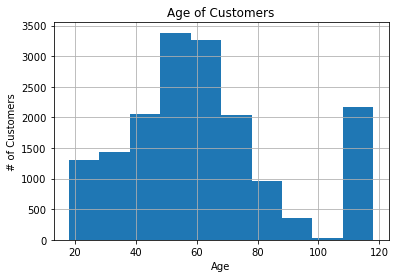

In [14]:
profile.age.hist()
plt.title('Age of Customers')
plt.xlabel('Age')
plt.ylabel('# of Customers');

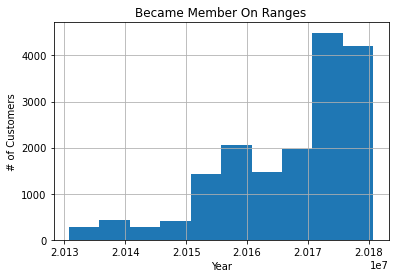

In [15]:
profile.became_member_on.hist()
plt.title('Became Member On Ranges')
plt.xlabel('Year')
plt.ylabel('# of Customers');

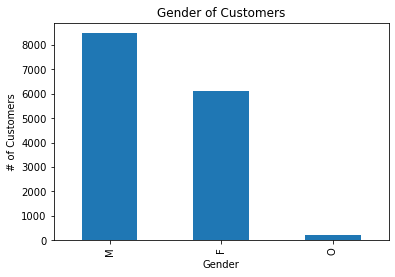

In [16]:
profile.gender.value_counts().plot(kind='bar')
plt.title('Gender of Customers')
plt.xlabel('Gender')
plt.ylabel('# of Customers');

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [18]:
profile.id.nunique()

17000

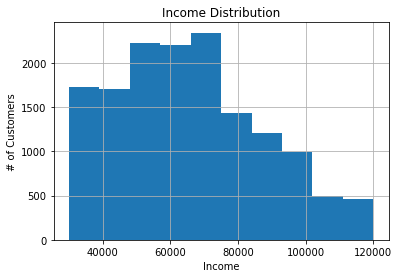

In [19]:
profile.income.hist()
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('# of Customers');

In [20]:
profile = profile.rename(columns={'id': 'person'})

In [21]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### Transcript - Exploratory Data Analysis

In [22]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
transcript[transcript.person == 'a03223e636434f42ac4c3df47e8bac43']

,person,event,value,time
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
15562,a03223e636434f42ac4c3df47e8bac43,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},6
90553,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 1.09},234
97700,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 3.5},264
110829,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
123539,a03223e636434f42ac4c3df47e8bac43,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
150599,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408
201573,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504
245125,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},576
277104,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 0.06},612


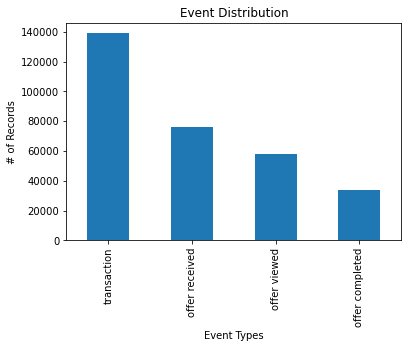

In [24]:
transcript.event.value_counts().plot(kind='bar')
plt.title('Event Distribution')
plt.xlabel('Event Types')
plt.ylabel('# of Records');

### Transcript - Data Cleaning

In [25]:
# Create a Tranaction dataframe with only transaction event types
transaction = transcript[transcript.event == 'transaction'].reset_index(drop=True)
transaction.head()

,person,event,value,time
0,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
2,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [26]:
# convert transaction amounts into a dataframe 
transaction_value = transaction.value.apply(pd.Series)
transaction_value.head()

,amount
0,0.83
1,34.56
2,13.23
3,19.51
4,18.97


In [27]:
# merge the transaction and transaction_value datasets
transaction = transaction.merge(transaction_value, left_index=True, right_index=True)
transaction.head()

,person,event,value,time,amount
0,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
2,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97


In [28]:
# drop the value and time column from the transaction dataset
transaction = transaction.drop(columns = ['value', 'time'])
transaction.head()

,person,event,amount
0,02c083884c7d45b39cc68e1314fec56c,transaction,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56
2,54890f68699049c2a04d415abc25e717,transaction,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97


In [29]:
# Find the Avg Transaction Amount for Each Person
avg_transaction = transaction.groupby('person').mean()['amount'].round(2)
avg_transaction.head()

person
0009655768c64bdeb2e877511632db8f    15.95
00116118485d4dfda04fdbaba9a87b5c     1.36
0011e0d4e6b944f998e987f904e8c1e5    15.89
0020c2b971eb4e9188eac86d93036a77    24.61
0020ccbbb6d84e358d3414a3ff76cffd    12.84
Name: amount, dtype: float64

In [30]:
avg_transaction = avg_transaction.to_frame()
avg_transaction.head()

,amount
person,
0009655768c64bdeb2e877511632db8f,15.95
00116118485d4dfda04fdbaba9a87b5c,1.36
0011e0d4e6b944f998e987f904e8c1e5,15.89
0020c2b971eb4e9188eac86d93036a77,24.61
0020ccbbb6d84e358d3414a3ff76cffd,12.84


In [31]:
avg_transaction = avg_transaction.rename(columns={'amount': 'avg_transaction'})
avg_transaction.head()

,avg_transaction
person,
0009655768c64bdeb2e877511632db8f,15.95
00116118485d4dfda04fdbaba9a87b5c,1.36
0011e0d4e6b944f998e987f904e8c1e5,15.89
0020c2b971eb4e9188eac86d93036a77,24.61
0020ccbbb6d84e358d3414a3ff76cffd,12.84


In [32]:
# Create a dataframe with only offer received event types
offer_received = transcript[transcript.event == 'offer received'].reset_index(drop=True)
offer_received.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [33]:
# clean offer_ids in value column to varible offer_received_value 
offer_received_value = offer_received.value.apply(pd.Series)
offer_received_value.head()

,offer id
0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2906b810c7d4411798c6938adc9daaa5
3,fafdcd668e3743c1bb461111dcafc2a4
4,4d5c57ea9a6940dd891ad53e9dbe8da0


In [34]:
# merge the offer_received and offer_recieved_value dataframes
offer_received = offer_received.merge(offer_received_value, right_index=True, left_index=True)
offer_received.head()

,person,event,value,time,offer id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [35]:
# drop the value and time columns
offer_received = offer_received.drop(columns = ['value', 'time'])
offer_received.head()

,person,event,offer id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0


In [36]:
# create a new dataframe called promos
# rename the event column to offer recieved, and the offer id column to offer_id
promos = offer_received.rename(columns={'event':'offer_recieved', 'offer id': 'offer_id'})
promos.head()

,person,offer_recieved,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0


In [37]:
# update the offer recieved column to a binary decision where 1 = offer recieved and 0 = offer not recieved
promos['offer_recieved'] = promos['offer_recieved'].apply(lambda x: 1 if x == 'offer received' else 0)
promos.head()

,person,offer_recieved,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,1,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,1,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,1,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,1,4d5c57ea9a6940dd891ad53e9dbe8da0


In [38]:
# rearrange columns
promos = promos[['person', 'offer_id', 'offer_recieved']]
promos.head()

,person,offer_id,offer_recieved
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [39]:
# Create a new dataframe with only offer viewed event types
viewed = transcript[transcript.event == 'offer viewed'].reset_index(drop=True)
viewed.head()

,person,event,value,time
0,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
1,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
2,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [40]:
# clean up the value column in the viewed dataframe and save to variable called offer_viewed_value
offer_viewed_value = viewed.value.apply(pd.Series)
offer_viewed_value.head()

,offer id
0,f19421c1d4aa40978ebb69ca19b0e20d
1,5a8bc65990b245e5a138643cd4eb9837
2,4d5c57ea9a6940dd891ad53e9dbe8da0
3,ae264e3637204a6fb9bb56bc8210ddfd
4,5a8bc65990b245e5a138643cd4eb9837


In [41]:
# merge viewed and offer_viewed_value dataframes
viewed = viewed.merge(offer_viewed_value, left_index=True, right_index=True)
viewed.head()

,person,event,value,time,offer id
0,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837


In [42]:
# drop the value column from the viewed dataframe
viewed = viewed.drop(columns = ['value', 'time'])
viewed.head()

,person,event,offer id
0,389bc3fa690240e798340f5a15918d5c,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,offer viewed,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,5a8bc65990b245e5a138643cd4eb9837


In [43]:
viewed = viewed.rename(columns={'offer id': 'offer_id'})
viewed.head()

,person,event,offer_id
0,389bc3fa690240e798340f5a15918d5c,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,offer viewed,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,5a8bc65990b245e5a138643cd4eb9837


In [44]:
# merge the promos and the viewed dataset on the person and offer id columns
promos = pd.merge(promos, viewed, how='left', left_on=['person', 'offer_id'], right_on=['person', 'offer_id'])
promos.head()

,person,offer_id,offer_recieved,event
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,offer viewed
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,offer viewed
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,offer viewed
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,offer viewed
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed


In [45]:
# update the event column to a binary decision where 1 = offer recieved and 0 = offer not recieved
promos['event'] = promos['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
promos.head()

,person,offer_id,offer_recieved,event
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1


In [46]:
# rename event column to offer viewed
promos = promos.rename(columns = {'event':'offer_viewed'})
promos.head()

,person,offer_id,offer_recieved,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1


In [47]:
# create new dataframe for completed offers
completed = transcript[transcript.event == 'offer completed'].reset_index(drop=True)
completed.head()

,person,event,value,time
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
2,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
3,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [48]:
# clean up the value column in the completed dataframe and save to variable called offer_completed_value
offer_completed_value = completed.value.apply(pd.Series)
offer_completed_value.head()

,offer_id,reward
0,2906b810c7d4411798c6938adc9daaa5,2
1,fafdcd668e3743c1bb461111dcafc2a4,2
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,ae264e3637204a6fb9bb56bc8210ddfd,10
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [49]:
# merge completed and offer_viewed_value dataframes
completed = completed.merge(offer_completed_value, left_index=True, right_index=True)
completed.head()

,person,event,value,time,offer_id,reward
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,2
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,2
2,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd,10
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [50]:
# drop the value column from the completed dataframe
completed = completed.drop(columns = ['value', 'time'])
completed.head()

,person,event,offer_id,reward
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,2906b810c7d4411798c6938adc9daaa5,2
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,fafdcd668e3743c1bb461111dcafc2a4,2
2,629fc02d56414d91bca360decdfa9288,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,676506bad68e4161b9bbaffeb039626b,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,10
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [51]:
# merge the promos and the viewed dataset on the person and offer id columns
promos = pd.merge(promos, completed, how='left', left_on=['person', 'offer_id'], right_on=['person', 'offer_id'])
promos.head()

,person,offer_id,offer_recieved,offer_viewed,event,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,offer completed,5.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,NaN,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,NaN,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,NaN,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,NaN,NaN


In [52]:
# update the event column to a binary decision where 1 = offer completed and 0 = offer not completed
promos['event'] = promos['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
promos.head()

,person,offer_id,offer_recieved,offer_viewed,event,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN


In [53]:
# rename event column to offer viewed
promos = promos.rename(columns = {'event':'offer_completed'})
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN


In [54]:
#rearrange columns for coherency
promos = promos[['person', 'offer_id', 'offer_recieved', 'offer_viewed', 'offer_completed', 'reward']]
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN


In [55]:
promos['offer_recieved'].sum()

115609

In [56]:
promos['offer_viewed'].sum()

98933

In [57]:
promos['offer_completed'].sum()

67397

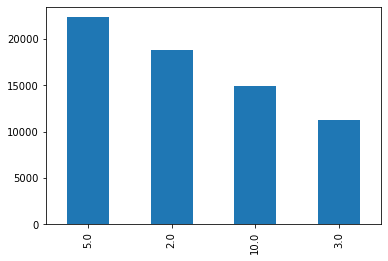

In [58]:
promos.reward.value_counts().plot(kind='bar');

In [59]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [60]:
# merge profile and promos dataset
promos = pd.merge(promos, profile, how='left', left_on='person', right_on='person')
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,M,68,20180426,70000.0
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN,None,118,20170925,NaN


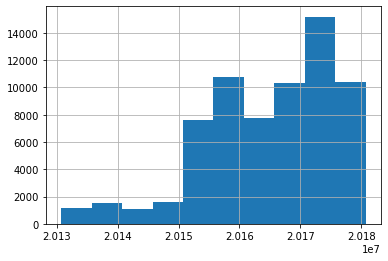

In [61]:
# create histogram for the distribution of when customers who completed the offer become members
promos[promos['offer_completed'] == 1]['became_member_on'].hist();

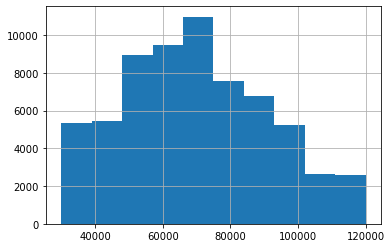

In [62]:
# create a histogram of the incomes of those who completed the offer
promos[promos['offer_completed'] == 1]['income'].hist();

In [63]:
# drop the reward column from the portfolio dataframe
portfolio = portfolio.drop(columns=['reward'])

In [64]:
# merge the promos and portfolio dataframes on the offer_id
promos = pd.merge(promos, portfolio, how = 'left', left_on='offer_id', right_on='offer_id')
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,F,75,20170509,100000.0,5,7,0,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN,20,10,2,1,0,0,1
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN,20,10,2,1,0,0,1
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,M,68,20180426,70000.0,10,7,2,1,1,0,1
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN,None,118,20170925,NaN,10,10,2,1,1,1,1


In [65]:
# add each customers avg transaction into the promos dataframe
promos = pd.merge(promos, avg_transaction, how = 'left', left_on='person', right_on='person')
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,F,75,20170509,100000.0,5,7,0,1,1,0,1,22.75
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN,20,10,2,1,0,0,1,1.55
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN,20,10,2,1,0,0,1,1.55
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,M,68,20180426,70000.0,10,7,2,1,1,0,1,19.24
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN,None,118,20170925,NaN,10,10,2,1,1,1,1,NaN


In [66]:
# create a new column called promo_worked that shows when a promo sucessfully got a customer to spend more than avg.
# Where the customer viewed the offer and completed the offer and the promo difficulty was greater than the customer avg transaction.
promos['promo_worked'] = np.where((promos['offer_viewed'] == 1) & (promos['offer_completed'] == 1) & (promos['difficulty'] > promos['avg_transaction']), 1, 0)

In [67]:
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,age,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction,promo_worked
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,F,75,20170509,100000.0,5,7,0,1,1,0,1,22.75,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN,20,10,2,1,0,0,1,1.55,0
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,118,20170804,NaN,20,10,2,1,0,0,1,1.55,0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,M,68,20180426,70000.0,10,7,2,1,1,0,1,19.24,0
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN,None,118,20170925,NaN,10,10,2,1,1,1,1,NaN,0


### Data PreProcessing

In [68]:
# drop age columns
promos = promos.drop(columns = ['age'])

In [69]:
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction,promo_worked
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,F,20170509,100000.0,5,7,0,1,1,0,1,22.75,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,20170804,NaN,20,10,2,1,0,0,1,1.55,0
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,NaN,None,20170804,NaN,20,10,2,1,0,0,1,1.55,0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,M,20180426,70000.0,10,7,2,1,1,0,1,19.24,0
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,NaN,None,20170925,NaN,10,10,2,1,1,1,1,NaN,0


In [70]:
promos.shape

(115609, 18)

In [71]:
#filter out rows where gener is null
promos = promos[promos.gender.notnull()].reset_index(drop=True)

In [72]:
# update null values in avg_transaction to O.00
promos['avg_transaction'] = np.where(promos['avg_transaction'].isnull(), '0.00', promos['avg_transaction'])
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction,promo_worked
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,F,20170509,100000.0,5,7,0,1,1,0,1,22.75,0
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,M,20180426,70000.0,10,7,2,1,1,0,1,19.24,0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,M,20180209,53000.0,5,5,0,1,1,1,1,12.14,0
3,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,M,20180209,53000.0,5,5,0,1,1,1,1,12.14,0
4,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,M,20180209,53000.0,5,5,0,1,1,1,1,12.14,0


In [73]:
# update the gender column to a binary decision 0 = M and 1 = F
promos['gender'] = promos['gender'].apply(lambda x: 0 if x == 'M' else 1)
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction,promo_worked
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,1,20170509,100000.0,5,7,0,1,1,0,1,22.75,0
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,NaN,0,20180426,70000.0,10,7,2,1,1,0,1,19.24,0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14,0
3,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14,0
4,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14,0


In [74]:
# replace null values in the roward column with 0.0
promos['reward'] = np.where(promos['reward'].isnull(), '0.0', promos['reward'])
promos.head()

,person,offer_id,offer_recieved,offer_viewed,offer_completed,reward,gender,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction,promo_worked
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5.0,1,20170509,100000.0,5,7,0,1,1,0,1,22.75,0
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,1,0,0.0,0,20180426,70000.0,10,7,2,1,1,0,1,19.24,0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14,0
3,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14,0
4,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14,0


In [75]:
promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102693 entries, 0 to 102692
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            102693 non-null  object 
 1   offer_id          102693 non-null  object 
 2   offer_recieved    102693 non-null  int64  
 3   offer_viewed      102693 non-null  int64  
 4   offer_completed   102693 non-null  int64  
 5   reward            102693 non-null  object 
 6   gender            102693 non-null  int64  
 7   became_member_on  102693 non-null  int64  
 8   income            102693 non-null  float64
 9   difficulty        102693 non-null  int64  
 10  duration          102693 non-null  int64  
 11  offer_type        102693 non-null  int64  
 12  email             102693 non-null  int64  
 13  mobile            102693 non-null  int64  
 14  social            102693 non-null  int64  
 15  web               102693 non-null  int64  
 16  avg_transaction   10

In [76]:
promos['avg_transaction'] = pd.to_numeric(promos['avg_transaction'])

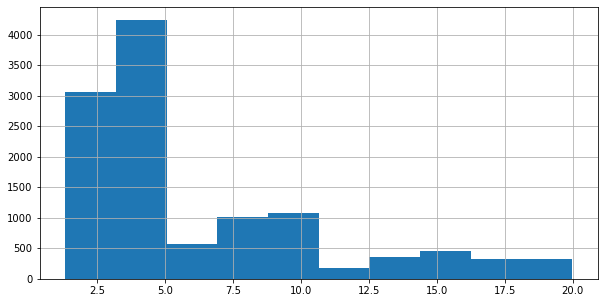

In [77]:
promos[promos.promo_worked == 1]['avg_transaction'].hist(figsize = (10,5));

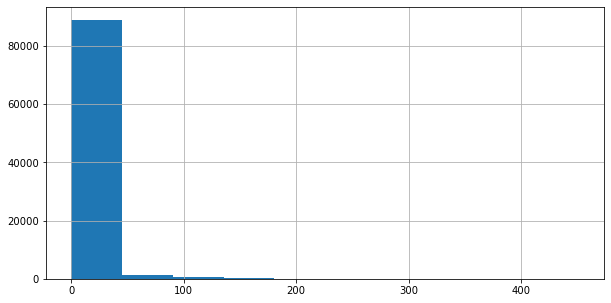

In [78]:
promos[promos.promo_worked == 0]['avg_transaction'].hist(bins = 10, figsize = (10,5));

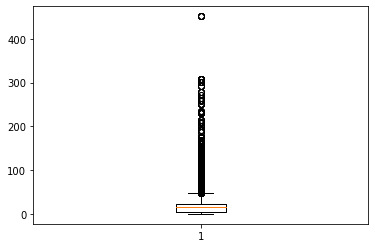

In [111]:
plt.boxplot(promos.avg_transaction);

In [112]:
promos.avg_transaction.mean()

16.018577118206455

### Build Model

In [80]:
# set promo_worked as y variable
y = promos.promo_worked
y.head()

0    0
1    0
2    0
3    0
4    0
Name: promo_worked, dtype: int64

In [81]:
x = promos.drop(columns = ['promo_worked', 'person', 'offer_id', 'offer_completed'])

In [82]:
x.head()

,offer_recieved,offer_viewed,reward,gender,became_member_on,income,difficulty,duration,offer_type,email,mobile,social,web,avg_transaction
0,1,1,5.0,1,20170509,100000.0,5,7,0,1,1,0,1,22.75
1,1,1,0.0,0,20180426,70000.0,10,7,2,1,1,0,1,19.24
2,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14
3,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14
4,1,1,5.0,0,20180209,53000.0,5,5,0,1,1,1,1,12.14


In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [84]:
x_train.shape

(82154, 14)

In [85]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([72790,  9364]))

In [102]:
model = DecisionTreeClassifier(random_state=1000)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1000)

In [103]:
y_pred = model.predict(x_test)

In [104]:
print("Model Accuracy:", metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 1.0


In [105]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[18289     0]
 [    0  2250]]


In [106]:
# dot_data = tree.export_graphviz(model, out_file=None, 
                                # feature_names=x.columns,  
                                # class_names=['0','1'],
                                # filled=True)

# Draw graph
# graph = graphviz.Source(dot_data, format="png") 
# graph

In [108]:
model.feature_importances_

array([0.        , 0.13130634, 0.48306721, 0.        , 0.        ,
       0.        , 0.14378296, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.24184349])

<BarContainer object of 14 artists>

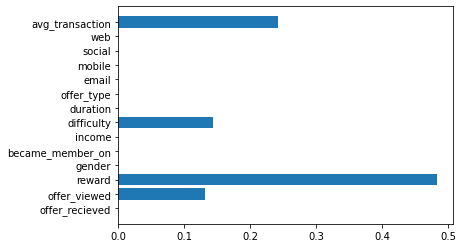

In [109]:
plt.barh(x.columns, model.feature_importances_)

## Explore Results

In [92]:
promo_worked = promos[promos.promo_worked == 1]

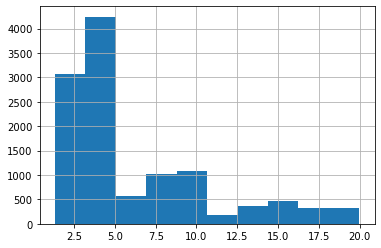

In [116]:
promo_worked.avg_transaction.hist();

In [113]:
promo_worked.avg_transaction.mean()

6.181668675736187

In [115]:
promo_worked.avg_transaction.max()

19.98

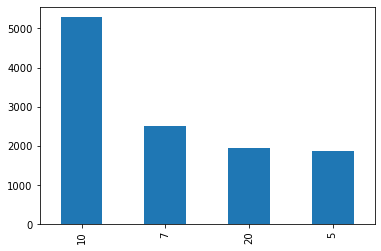

In [117]:
promo_worked.difficulty.value_counts().plot(kind='bar');

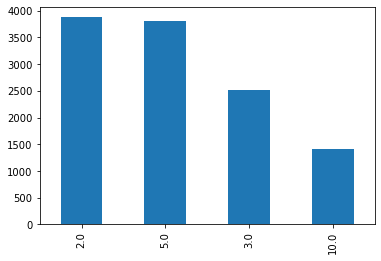

In [114]:
promo_worked.reward.value_counts().plot(kind='bar');

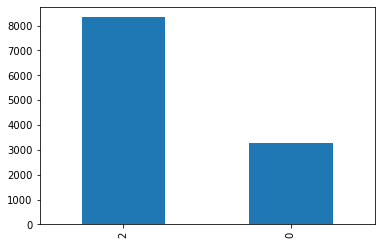

In [118]:
promo_worked.offer_type.value_counts().plot(kind='bar');